In [1]:
from qiskit import *
import math
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
get_ipython().run_line_magic('matplotlib', 'inline')
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.circuit.library import SXdgGate
import numpy as np
import matplotlib.pyplot as plt


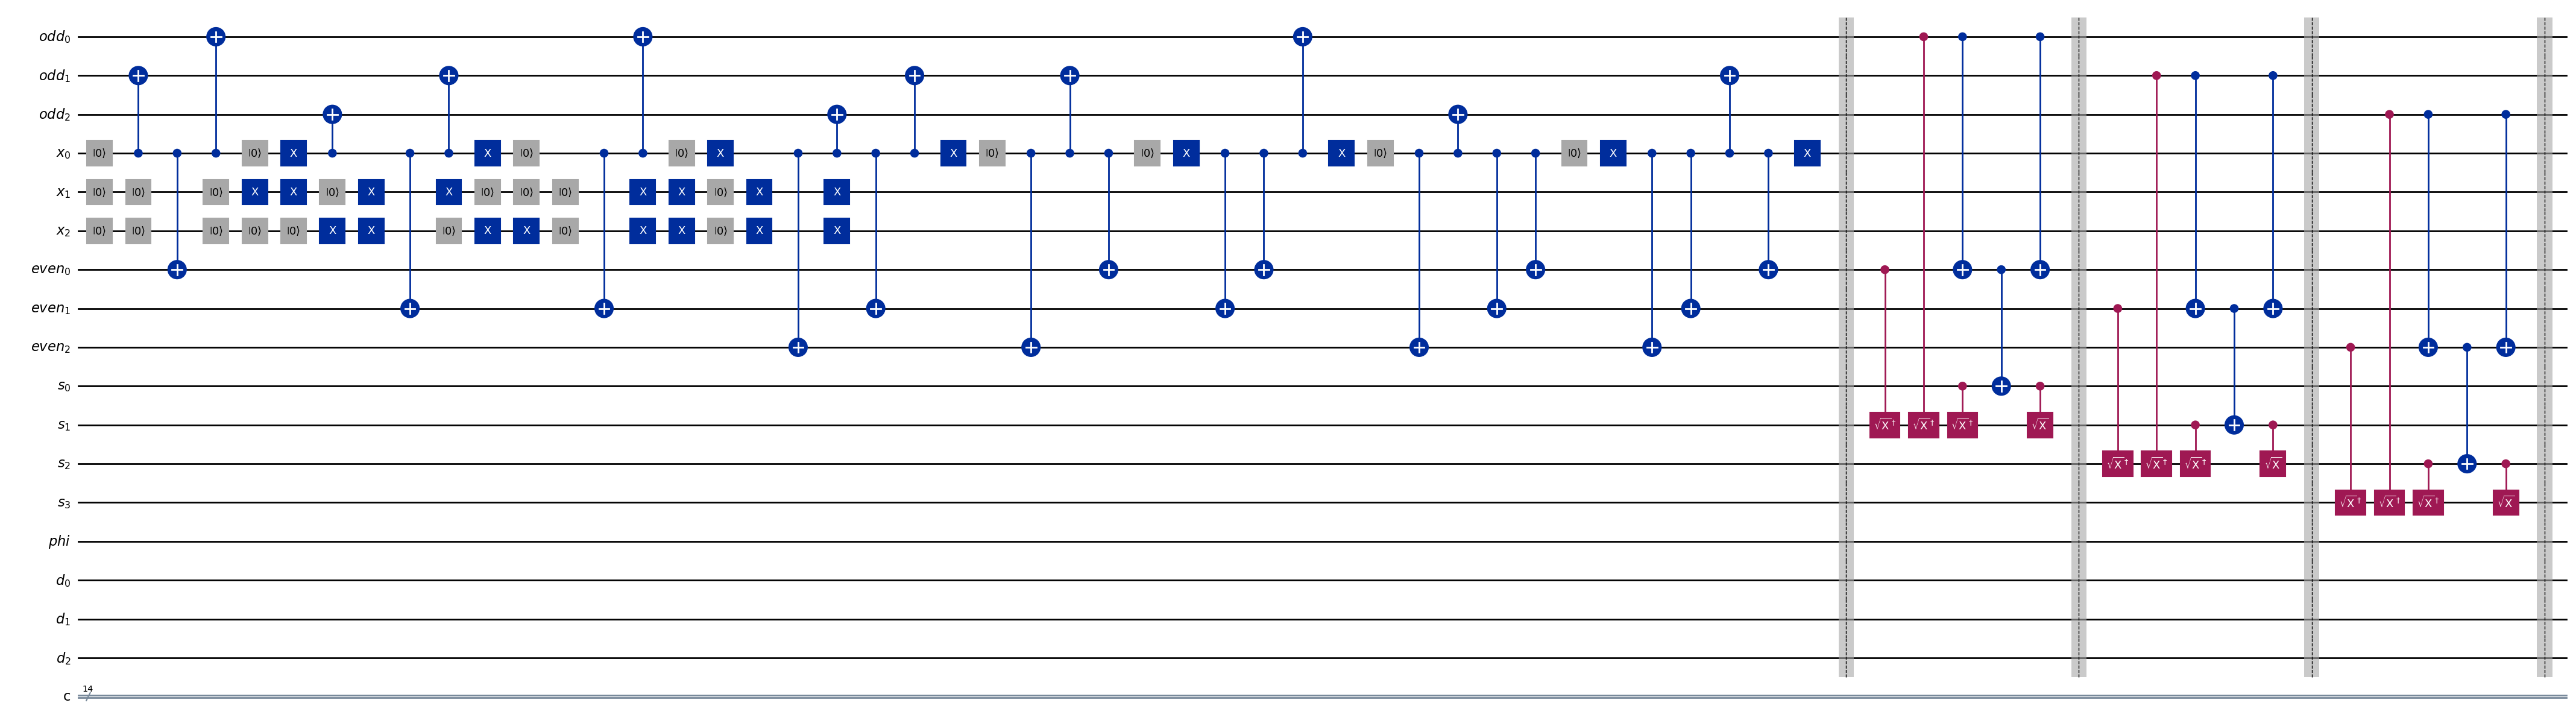

In [3]:


# 假设输入4x4图像
image = np.array([
    [1, 3, 2, 1],
    [2, 6, 6, 6],
    [5, 2, 7, 4],
    [3, 1, 7, 2]
])

# 展开为一维，方便统一处理
pixels = image.flatten()  # 长度16

bit_precision = 3  # 每个像素3位
num_blocks = 4     # 4个2x2块
block_size = 4     # 每块4个像素
num_pos_bits = 3   # 3个位置比特可区分8个位置，足够区分4块内的4个像素

# 量子寄存器
odd_e = QuantumRegister(bit_precision, 'odd')
even_e = QuantumRegister(bit_precision, 'even')
x_pos = QuantumRegister(num_pos_bits, 'x')  # 3位位置
add_q = QuantumRegister(bit_precision + 1, 's')
OE = QuantumRegister(1, 'phi')
sub_q = QuantumRegister(bit_precision, 'd')
cr = ClassicalRegister(bit_precision*2 + num_pos_bits + bit_precision + 2, 'c')

qc = QuantumCircuit(odd_e, x_pos, even_e, add_q, OE, sub_q, cr)
csxdg_gate = SXdgGate().control()

# 对每个像素对（每个2x2块内的偶/奇像素）进行编码
for block_idx in range(num_blocks):
    # 计算块的起始像素索引
    block_row = (block_idx // 2) * 2
    block_col = (block_idx % 2) * 2
    block_pixels = [
        image[block_row, block_col],     # (0,0)
        image[block_row, block_col+1],   # (0,1)
        image[block_row+1, block_col],   # (1,0)
        image[block_row+1, block_col+1]  # (1,1)
    ]
    # 每个块内有两个位置（0/1），每个位置有偶/奇像素
    for local_pos in range(2):
        # 全局位置编码：3位
        # block_idx: 2位（00,01,10,11），local_pos: 1位
        pos_bits = f"{block_idx:02b}{local_pos:01b}"  # 3位字符串
        # 先将x_pos全部复位
        for i in range(num_pos_bits):
            if x_pos[i] in qc.qubits:
                qc.reset(x_pos[i])
        # 设置位置比特
        for i, bit in enumerate(pos_bits):
            if bit == '1':
                qc.x(x_pos[num_pos_bits-1-i])
        # 信号编码
        even_val = int(block_pixels[2*local_pos])
        odd_val = int(block_pixels[2*local_pos+1])
        S_even = bin(even_val)[2:].zfill(bit_precision)
        S_odd = bin(odd_val)[2:].zfill(bit_precision)
        for i in range(bit_precision):
            if S_even[i] == '1':
                qc.cx(x_pos[0], even_e[bit_precision-1-i])
            if S_odd[i] == '1':
                qc.cx(x_pos[0], odd_e[bit_precision-1-i])
        # 还原位置比特
        for i, bit in enumerate(pos_bits):
            if bit == '1':
                qc.x(x_pos[num_pos_bits-1-i])
qc.barrier()

# S变换门操作（对所有像素并行）
for ii in range(bit_precision):
    qc.append(csxdg_gate, [even_e[ii], add_q[ii+1]])
    qc.append(csxdg_gate, [odd_e[ii], add_q[ii+1]])
    qc.append(csxdg_gate, [add_q[ii], add_q[ii+1]])
    qc.cx(odd_e[ii], even_e[ii])
    qc.cx(even_e[ii], add_q[ii])
    qc.cx(odd_e[ii], even_e[ii])
    qc.csx(add_q[ii], add_q[ii+1])
    qc.barrier()


# 画电路图
qc.draw(output='mpl', fold=-1)
plt.show()

In [1]:
from qiskit import Aer
print(Aer.backends())


ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.